# Gaussian Processes

## Introduction

[Gaussian Processes](https://en.wikipedia.org/wiki/Gaussian_process) have been used in supervised, unsupervised, and even reinforcement learning problems and are described by an elegant mathematical theory (for an overview of the subject see [1, 4]). They are also very attractive conceptually, since they offer an intuitive way to define priors over functions. And finally, since Gaussian Processes are formulated in a Bayesian setting, they come equipped with a powerful notion of uncertainty. 

Happily, Pyro offers some support for Gaussian Processes in the `pyro.contrib.gp` module. The goal of this tutorial is to give a brief introduction to Gaussian Processes (GPs) in the context of this module. We will mostly be focusing on how to use the GP interface in Pyro and refer the reader to the references for more details about GPs in general.

The model we're interested in is defined by
$$f \sim \mathcal{GP}\left(0, \mathbf{K}_f(x, x')\right)$$
and
$$y = f + \epsilon,\quad \epsilon \sim \mathcal{N}\left(0, \beta^{-1}\mathbf{I}\right).$$
Here $x, x' \in\mathbf{X}$ are points in the input space and $y\in\mathbf{Y}$ is a point in the output space. $f$ is a draw from the GP prior specified by the kernel $\mathbf{K}_f$ and represents a function from $\mathbf{X}$ to $\mathbf{Y}$. Finally, $\epsilon$ represents gaussian observation noise.

We will use the [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF kernel) as the kernel of our GP:
$$ k(x,x') = \sigma^2 \exp\left(-\frac{\|x-x'\|^2}{2l^2}\right).$$
Here $\sigma^2$ and $l$ are parameters that specify the kernel; specifically, $\sigma^2$ is a variance or amplitude squared and $l$ is a lengthscale. We'll get some intuition for these parameters below.

## Imports

First, we import necessary modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch

import pyro
from pyro.contrib.gp.kernels import RBF
from pyro.contrib.gp.models import GPRegression, SparseGPRegression, SparseVariationalGP
from pyro.contrib.gp.likelihoods import Gaussian
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import os

smoke_test = ('CI' in os.environ) # ignore; (this is for checking code integrity in the Pyro repo)
pyro.enable_validation(True)  # can help with debugging
pyro.clear_param_store()      # clear the param store
pyro.set_rng_seed(0)

Throughout the tutorial we'll want to visualize GPs. So we define a helper function for plotting:

In [2]:
# note that this helper function does three different things: 
# (i) plots the observed data; 
# (ii) plots the predictions from the learned GP after conditioning on data; 
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0, 
         model=None, kernel=None, n_test=500):
    
    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X.numpy(), y.numpy(), 'kx') 
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs        
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == SparseVariationalGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)                    
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(), # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(), 
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3) 
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs 
        cov = kernel.forward(Xtest) + model.noise.expand(n_test).diag()
        n_prior_samples = n_prior_samples if not smoke_test else 1
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
            
    plt.xlim(-0.5, 5.5)

## Data

The data consist of $20$ points sampled from
$$ y = 0.5\sin(3x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.2).$$
with $x$ sampled uniformly from the interval [0, 5].

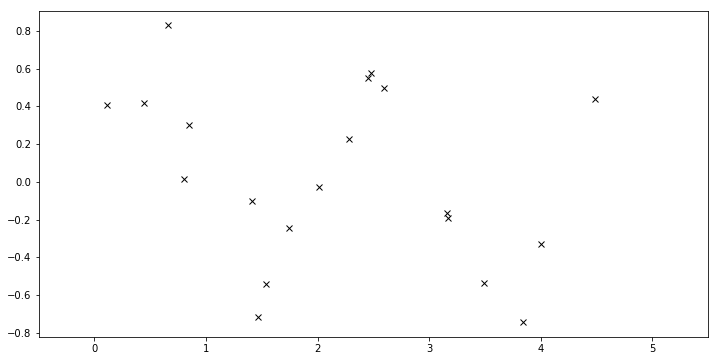

In [3]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

## Define model

First we define a RBF kernel, specifying the values of the two hyperparameters `variance` and `lengthscale`. Then we construct a `GPRegression` object. Here we feed in another hyperparameter, `noise`, that corresponds to $\epsilon$ above.

In [4]:
kernel = RBF(input_dim=1, variance=torch.tensor(5.), lengthscale=torch.tensor(10.))
gpr = GPRegression(X, y, kernel, noise=torch.tensor(1.))

Let's see what samples from this GP function prior look like. Note that this is _before_ we've conditioned on the data. The shape these functions take&mdash;their smoothness, their vertical scale, etc.&mdash;is controlled by the GP kernel.

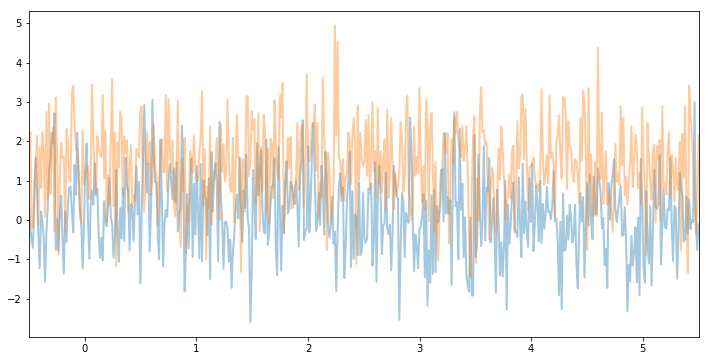

In [5]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)

For example, if we make `variance` and `noise` smaller we will see function samples with smaller vertical amplitude:

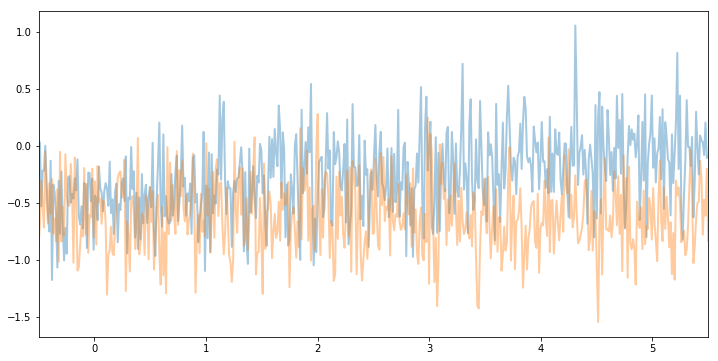

In [6]:
kernel2 = RBF(input_dim=1, variance=torch.tensor(0.1), lengthscale=torch.tensor(10.))
gpr2 = GPRegression(X, y, kernel2, noise=torch.tensor(0.1))
plot(model=gpr2, kernel=kernel2, n_prior_samples=2)

## Inference

In the above we set the kernel hyperparameters by hand. If we want to learn the hyperparameters from the data, we need to do inference. In the simplest (conjugate) case we do gradient ascent on the log marginal likelihood. In `pyro.contrib.gp` we just use the Pyro `SVI` inferface (even though we're not sampling any latent random variables in this case).

In [7]:
optim = Adam({"lr": 0.005})
svi = SVI(gpr.model, gpr.guide, optim, loss=Trace_ELBO())
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps): 
    losses.append(svi.step())

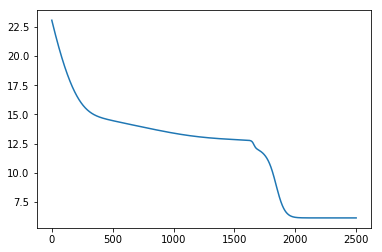

In [8]:
# let's plot the loss curve after 2500 steps of training
plt.plot(losses);

Let's see if we're learned anything reasonable:

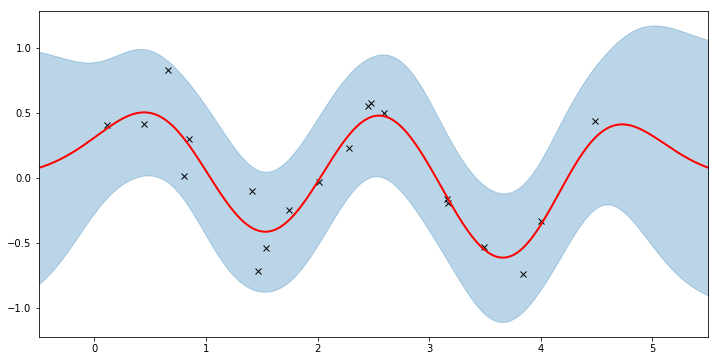

In [9]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

Here the thick red curve is the mean prediction and the blue band represents the 2-sigma uncertainty around the mean. It seems we learned reasonable kernel hyperparameters, as both the mean and uncertainty give a reasonable fit to the data. (Note that learning could have easily gone wrong if we e.g. chose too large of a learning rate or chose bad initital hyperparameters.)

Note that the kernel is only well-defined if `variance` and `lengthscale` are positive. Under the hood Pyro is using PyTorch constraints (see [docs](http://pytorch.org/docs/master/distributions.html#module-torch.distributions.constraints)) to ensure that hyperparameters are constrained to the appropriate domains. To see the constrained values of the hyperparameters, we will use the `get_param(...)` method.

In [10]:
gpr.kernel.get_param("variance").item()

0.20291326940059662

In [11]:
gpr.kernel.get_param("lengthscale").item()

0.5022145509719849

In [12]:
gpr.get_param("noise").item()

0.04273039102554321

Note that the period of the sinusoid that generated the data is $T = 2\pi/3 \approx 2.09$ so learning a lengthscale that's approximiately equal to a quarter period makes sense.

### Fit the model using MAP

We need to define priors for the hyperparameters.

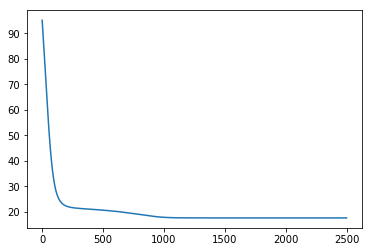

In [13]:
# note that our priors have support on the positive reals
gpr.kernel.set_prior("lengthscale", dist.LogNormal(0.0, 1.0))
gpr.kernel.set_prior("variance", dist.LogNormal(0.0, 1.0))
# we fix the noise to 0.01
gpr.fix_param("noise", torch.ones(1) * 0.01)
# we reset the param store so that the previous inference doesn't interfere with this one
pyro.clear_param_store()
optim = Adam({"lr": 0.005})
svi = SVI(gpr.model, gpr.guide, optim, loss=Trace_ELBO())
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())
plt.plot(losses);

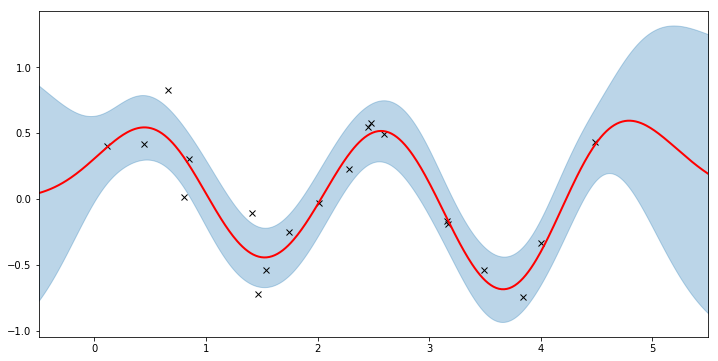

In [14]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

Let's inspect the hyperparameters we've learned:

In [15]:
for param, value in pyro.get_param_store().named_parameters():
    print(param, value.item())

('RBF$$$lengthscale_MAP', 0.5814493894577026)
('RBF$$$variance_MAP', 0.2934931814670563)


Note that the MAP values are different from the MLE values due to the prior. We can also see that the names of parameters have been changed. This is because by putting priors on the hyperparameters of our kernel, we have transformed them into into random variables (they are no longer `torch.nn.Parameter`s). Under the hood, the GP module appends a trailing `_MAP` to each hyperparameter name to reflect this difference.

## Sparse GPs

For large datasets computing the log marginal likelihood is costly due to the expensive matrix operations involved (e.g. see Section 2.2 of [1]). A variety of so-called 'sparse' variational methods have been developed to make GPs viable for larger datasets. This is a big area of research and we won't be going into all the details. Instead we quickly show how we can use `SparseGPRegression` in `pyro.contrib.gp` to make use of these methods.

First, we generate more data.

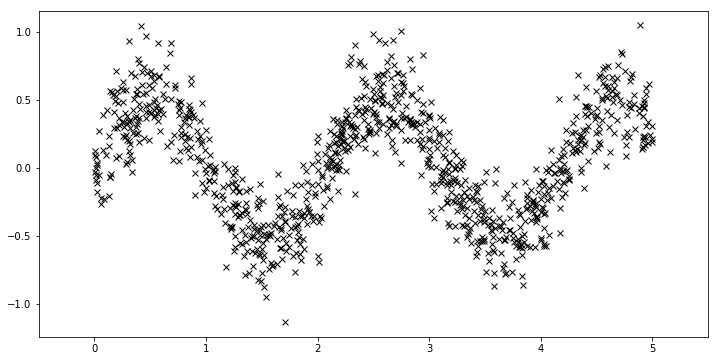

In [ ]:
N = 1000
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3*X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))
plot(plot_observed_data=True)

Using the sparse GP is very similar to using the basic GP used above. We just need to add an extra parameter $X_u$ (the inducing points).

In [ ]:
# initialize the position of the inducing inputs
Xu = torch.arange(20) / 4.0

# initialize the kernel and model
kernel = RBF(input_dim=1)
# we increase the jitter for better numerical stability
sgpr = SparseGPRegression(X, y, kernel, Xu=Xu, jitter=1.0e-4)

# the way we setup inference is similar to above
pyro.clear_param_store()
optim = Adam({"lr": 0.005})
svi = SVI(sgpr.model, sgpr.guide, optim, loss=Trace_ELBO())
losses = []
num_steps = 1500 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())
plt.plot(losses);

In [ ]:
for param, value in pyro.get_param_store().named_parameters():
    print(param, value.data.numpy())
plot(model=sgpr, plot_observed_data=True, plot_predictions=True)

We can see that the model learns a reasonable fit to the data. There are three different sparse approximations that are currently implemented in Pyro:
- "DTC" (Deterministic Training
Conditional)
- "FITC" (Partially Independent Training Conditional)
- "VFE" (Variational Free Energy) 

By default, `SparseGPRegression` will use "VFE" as the inference method. We can use other methods by passing a different `approx` flag to `SparseGPRegression`.

## Sparse Variational Gaussian Process

The noise in regression model plays the role of Gaussian likelihood. To deal with general likelihoods (for example, we can use the Bernoulli likelihood for classification problems), we will use variational inference. In this section, we will give an example on how to use `SparseVariationGP` module.

In [ ]:
# initialize the position of inducing inputs
Xu = torch.arange(10) / 2.0

# initialize the kernel, likelihood, and model
kernel = RBF(input_dim=1)
likelihood = Gaussian()
svgp = SparseVariationalGP(X, y, kernel, Xu=Xu, 
                           likelihood=likelihood, jitter=1e-4)
# fix the noise to 0.01
svgp.likelihood.fix_param("variance", torch.ones(1) * 0.01)

pyro.clear_param_store()
optim = Adam({"lr": 0.001})
svi = SVI(svgp.model, svgp.guide, optim, loss=Trace_ELBO())
losses = []
num_steps = 3000 if not smoke_test else 2
for i in range(num_steps):
    losses.append(svi.step())
plt.plot(losses);

In [ ]:
plot(model=svgp, plot_observed_data=True, plot_predictions=True)

We can see that the model predicts well the target $y = 0.5\sin(3x)$ despite of noisy data.

## Some remarks

+ In Gaussian Process, we usually have to solve the equation $Kx = y$, where $K$ is a positive covariance matrix. An efficiency and numerically-stable method to obtain the solution is to use [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). First, we decompose $K = LL^T$, where $L$ is a lower triangular matrix. Then, we solve in turn $Lz = y$ and $L^Tx = z$.

+ The Cholesky decomposition `torch.potrf` usually throws the `RuntimeError`: "Lapack Error in potrf : the leading minor of order {} is not positive definite". The error tells itself: while decomposing, some eigenvalues of covariance matrix are approximately $0$ (and turn out to be negative). To deal with such error, one way is to cast our model's parameters to `DoubleTensor` (by calling `.double` from our model). Another way is to introduce the notion `jitter`. We will add a small positive term (named `jitter`) into the diagonal part of $K$ before decomposing the covariance matrix. Due to the `noise` component, all eigenvalues will be positive. Adding `jitter` is necessary when using Gaussian Process in variational framework. By default, in each model, we set `jitter=1e-6`. When getting that error, we recommend increasing `jitter` to a higher value.

## Reference

[1] `Deep Gaussian processes and variational propagation of uncertainty`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Andreas Damianou

[2] `A unifying framework for sparse Gaussian process approximation using power expectation propagation`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Thang D. Bui, Josiah Yan, and Richard E. Turner

[3] `Scalable variational Gaussian process classification`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
James Hensman, Alexander G. de G. Matthews, and Zoubin Ghahramani

[4] `Gaussian Processes for Machine Learning`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Carl E. Rasmussen, and Christopher K. I. Williams

[5] `A Unifying View of Sparse Approximate Gaussian Process Regression`,<br />&nbsp;&nbsp;&nbsp;&nbsp;
Joaquin Quinonero-Candela, and Carl E. Rasmussen